# Uniswap V2
For this strategy, we will provide the liquidity just as in Uniswap v2. We will provide liquidity in the interval [minTick, maxTick].

Import code dependencies

In [1]:
from datetime import date, datetime
import pandas as pd

from demeter import TokenInfo, Actuator, Strategy, RowData, ChainType, MarketInfo, AtTimeTrigger
from demeter.result import performance_metrics, round_results
from demeter.uniswap import UniV3Pool, UniLpMarket

Set pandas output format

In [2]:
pd.options.display.max_columns = None
pd.set_option("display.width", 5000)

Custom Uniswap V2 strategy with add liquidity from tick -887272(minTick) to 887272(maxTick)

In [3]:
class UniswapV2Strategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  
            time=datetime(2024, 4, 1, 0, 0, 0), do=self.work  
        ) 
        self.triggers.append(new_trigger)  

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        lp_market: UniLpMarket = self.markets[market_key] 
        lp_market.add_liquidity_by_tick(-887272, 887272) 
        pass

Main logic to run Actuator, init two token and market with key "market1"

In [4]:

# Declare tokens with names to be used as units for amounts
usdc = TokenInfo(name="usdc", decimal=6)
eth = TokenInfo(name="eth", decimal=18)

# Initialize Uniswap V3 Pool with parameters matching the on-chain pool
pool = UniV3Pool(token0=usdc, token1=eth, fee=0.05, quote_token=usdc)

# Define market key and create the Uniswap V3 market
market_key = MarketInfo("market1")
market = UniLpMarket(market_key, pool)

# Load market data
market.data_path = "../data"
market.load_data(
    chain="ethereum",
    contract_addr="0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640",
    start_date=date(2024, 4, 1),
    end_date=date(2024, 9, 30)
)

# Initialize Actuator and configure the broker
actuator = Actuator()
actuator.broker.add_market(market)
actuator.broker.set_balance(usdc, 5000)
actuator.broker.set_balance(eth, 1)

# Set strategy and assign price data from the Uniswap pool
actuator.strategy = UniswapV2Strategy()
actuator.set_price(market.get_price_from_data())

# Run the test and display performance metrics
actuator.run()
print(round_results(performance_metrics(actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"])))

# Save results to the specified path
actuator.save_result(
    path="./result",
    account=True,
    actions=True
)

2024-11-25 15:12:49,517 - INFO - Quote token is USDC
2024-11-25 15:12:49,519 - INFO - init strategy...
2024-11-25 15:12:49,521 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 263520/263520 [02:02<00:00, 2150.69it/s]
2024-11-25 15:14:52,065 - INFO - main loop finished
2024-11-25 15:15:02,131 - INFO - Print actuator summary


Final account status                              
Token balance in broker       
USDC      :1356.1627                ETH       :0                        
Position value in markets     
market1(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
   lower_tick  upper_tick   pending0     pending1       liquidity
0     -887270      887270  76.062491  0.026803462  60364205529210

Quote by: USDC
Account balance history                           


2024-11-25 15:15:03,932 - INFO - Backtesting finished, execute time 134.42280054092407s


l1                  net_value    tokens       market1                                                                                          price     
l2                                 USDC ETH net_value base_uncollected quote_uncollected base_in_position quote_in_position position_count       ETH USDC
2024-04-01 00:00:00 8643.8381 1356.1627   0 7287.6754    2.0354647e-07      2.807403e-05                1         3643.8373              1 3643.8373    1
2024-04-01 00:01:00 8642.7454 1356.1627   0 7286.5827    2.9426983e-07      2.807403e-05          1.00015         3643.2908              1 3642.7444    1
2024-04-01 00:02:00 8640.1963 1356.1627   0 7284.0336    4.6598839e-07     2.8266948e-05        1.0005001         3642.0159              1 3640.1955    1
2024-04-01 00:03:00 8640.9252 1356.1627   0 7284.7625     5.104573e-07     0.00040942318        1.0004001         3642.3801              1 3640.9236    1
2024-04-01 00:04:00 8641.6542 1356.1627   0 7285.4915    5.5788621e-07     0

2024-11-25 15:15:07,645 - INFO - files have saved to ./result\backtest-20241125-151504.account.csv,./result\backtest-20241125-151504.pkl


['./result\\backtest-20241125-151504.account.csv',
 './result\\backtest-20241125-151504.pkl']

Run actuator with evaluators and save result to files

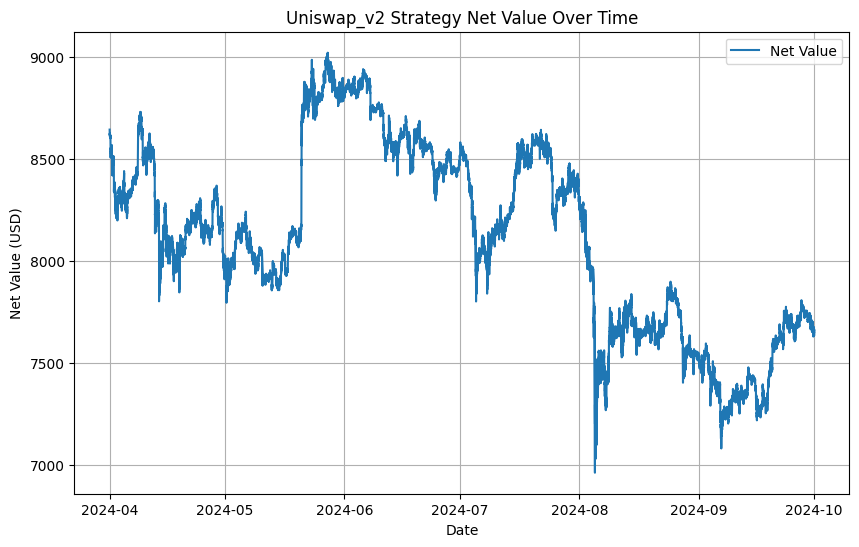

In [5]:
import matplotlib.pyplot as plt

# Plot the net_value of the strategy over time
plt.figure(figsize=(10, 6))
plt.plot(actuator.account_status_df.index, actuator.account_status_df["net_value"], label="Net Value")
plt.xlabel("Date")
plt.ylabel("Net Value (USD)")
plt.title("Uniswap_v2 Strategy Net Value Over Time")
plt.legend()
plt.grid(True)
plt.show()
